# Geochemical facies analysis using dimensionality reduction and K-means clustering

This program applies the dimensionality reduction and the K-means clustering algorithms a set of geochemical data. The data used here consists of X-ray fluorescence (XRF) measurements of cuttings from the lateral section of an unconventional well. For a refresher on XRF measurements, please refer to this wikpedia webpage on [XRF](https://en.wikipedia.org/wiki/X-ray_fluorescence). <br>
<br>
The XRF measurement that we are going to use were made at about 10-m intervals. At each depth, 22 measurements were made. Each measurement tells us the weight percentage of a chemical component. <br>
<br>


## 1. Import some modules and data

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
geochem_df = pd.read_csv('./XRF_dataset.csv')

## 2. Get to know our data

In [6]:
geochem_df.head()

,Well Name,Depth,Quartz,K-Feldspar,Plagioclase,Chlorite,IlliteSmectiteMica,Calcite,Ankerite/Dolomite,Pyrite,...,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SO3,Cl,Zr
0,Well 1,3173.97,27.56,0.40,8.17,5.46,20.73,26.11,9.30,1.94,...,3.40,0.02,0.53,19.49,0.78,1.19,0.20,1.20,0.28,201.70
1,Well 1,3183.11,42.92,0.64,9.63,4.10,15.61,18.31,5.07,1.51,...,2.08,0.02,0.09,15.52,0.93,1.01,0.19,0.81,0.26,395.35
2,Well 1,3192.26,44.55,0.56,10.07,4.33,15.17,16.78,6.14,0.80,...,2.14,0.02,0.15,15.52,0.87,0.98,0.18,0.76,0.23,362.70
3,Well 1,3201.40,42.65,0.38,9.04,4.02,14.56,21.27,4.49,1.06,...,2.26,0.02,0.14,15.46,0.87,1.05,0.22,0.96,0.26,410.10
4,Well 1,3210.54,42.61,1.26,8.95,3.66,15.53,19.77,4.35,1.10,...,2.39,0.02,0.21,18.65,0.82,1.06,0.25,1.16,0.24,401.50


Print out the names of the elements whose weight percentages were measured by XRF.

In [7]:
print(geochem_df.columns.values[2:])

['Quartz' 'K-Feldspar' 'Plagioclase' 'Chlorite' 'IlliteSmectiteMica'
 'Calcite' 'Ankerite/Dolomite' 'Pyrite' 'Organics' 'Al2O3' 'SiO2' 'TiO2'
 'Fe2O3' 'MnO' 'MgO' 'CaO' 'Na2O' 'K2O' 'P2O5' 'SO3' 'Cl' 'Zr']


Plot a few scatterplots to gain a sense of the measurments.

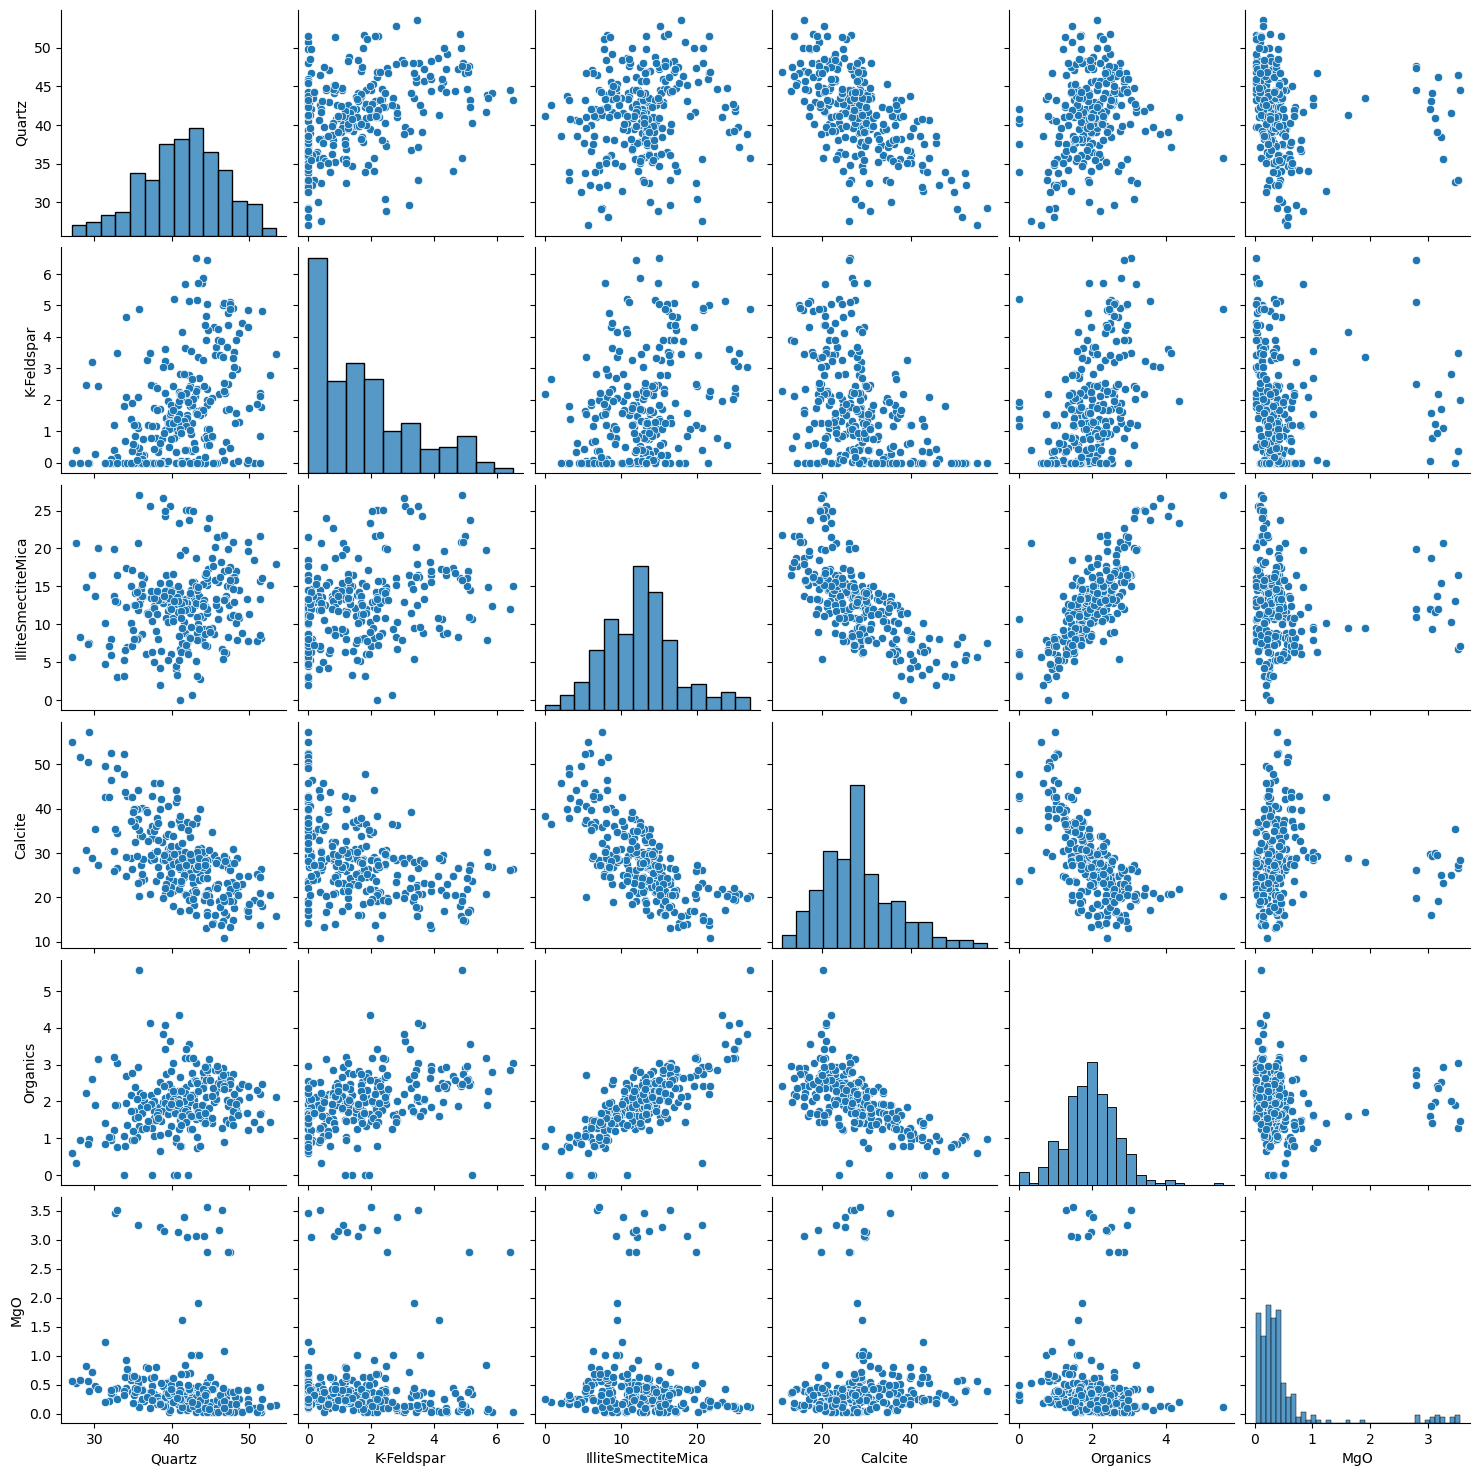

In [8]:
features = geochem_df.columns.values[2:]
input_feature_vectors = geochem_df[features]
sns.pairplot(input_feature_vectors[['Quartz','K-Feldspar','IlliteSmectiteMica','Calcite','Organics','MgO']])
plt.show()

There are some strong correlations between some of the elements. This is an important observation. The reason is that, K-means clustering can only discover spherical clusters, therefore, when there are some strong correlations among our measurements, the clusters will become elliptical, rather than spherical, making K-means less ideal for the clustering task.

## 3. Feature engineering

Feature engineering simply refers to the process of manually engineering/creating some new features based on existing features to help machine learning algorithms better get the job done. 

(The following was from Brendon Hall's article published on CSEG RECORDER) <br>
In geochemistry, elements are used as proxies that give hints to the physical, chemical or biological events that were occurring during rock formation. Ratios of certain elements can indicate the relative strength of various effects. We will focus on three ratios: Si/Zr, Si/Al, and Zr/Al. The Si/Zr ratio is used to indicate relative proportions of biogenic silica and terrestrial detrital inputs and the Si/Al ratio is used as a proxy for biogenic silica to aluminous clay (Croudace and Rothwell, 2015). The Zr/Al ratio is a proxy for terrigenous input; chemical behavior of Zr suggests that this ratio can be used as a proxy for grain size (Calvert and Pederson, 2007).

In [9]:
geochem_df['Si/Zr'] = geochem_df['SiO2'] / geochem_df['Zr']
geochem_df['Si/Al'] = geochem_df['SiO2'] / geochem_df['Al2O3']
geochem_df['Zr/Al'] = geochem_df['Zr'] / geochem_df['Al2O3']

## 4. Preprocessing data

For both PCA and K-means, I do need to standardize the measurements to make the ML algorithms work better. That is, I need to rescale the measurements for each feature so that they all have zero mean and unit variance. This can be easily done using Scikit-Learn's StandardScaler module.

In [10]:
data = geochem_df.iloc[:,2:]

In [11]:
scaler = StandardScaler().fit(data)
scaled_data = scaler.transform(data)

In [12]:
scaled_data.shape

(269, 25)

## 5. Implement PCA

Implement PCA using the number of principal components that preserves at least 90% of the variance in our measurements.  
<br>


In [13]:
from sklearn.decomposition import PCA
# Find principle components that preserves 90% of variance
pca = PCA()
pca.fit(scaled_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.90) + 1
print('Number of principle components to preserve 90% of variance is ' + str(d))

# Implement PCA at 90% variance
myPCA = PCA(n_components=d)
scaled_data_reduced = myPCA.fit_transform(scaled_data)
scaled_data_reduced.shape

Number of principle components to preserve 90% of variance is 10


(269, 10)

Use **sns.pairplot** to show the scatterplot between all principal components. 

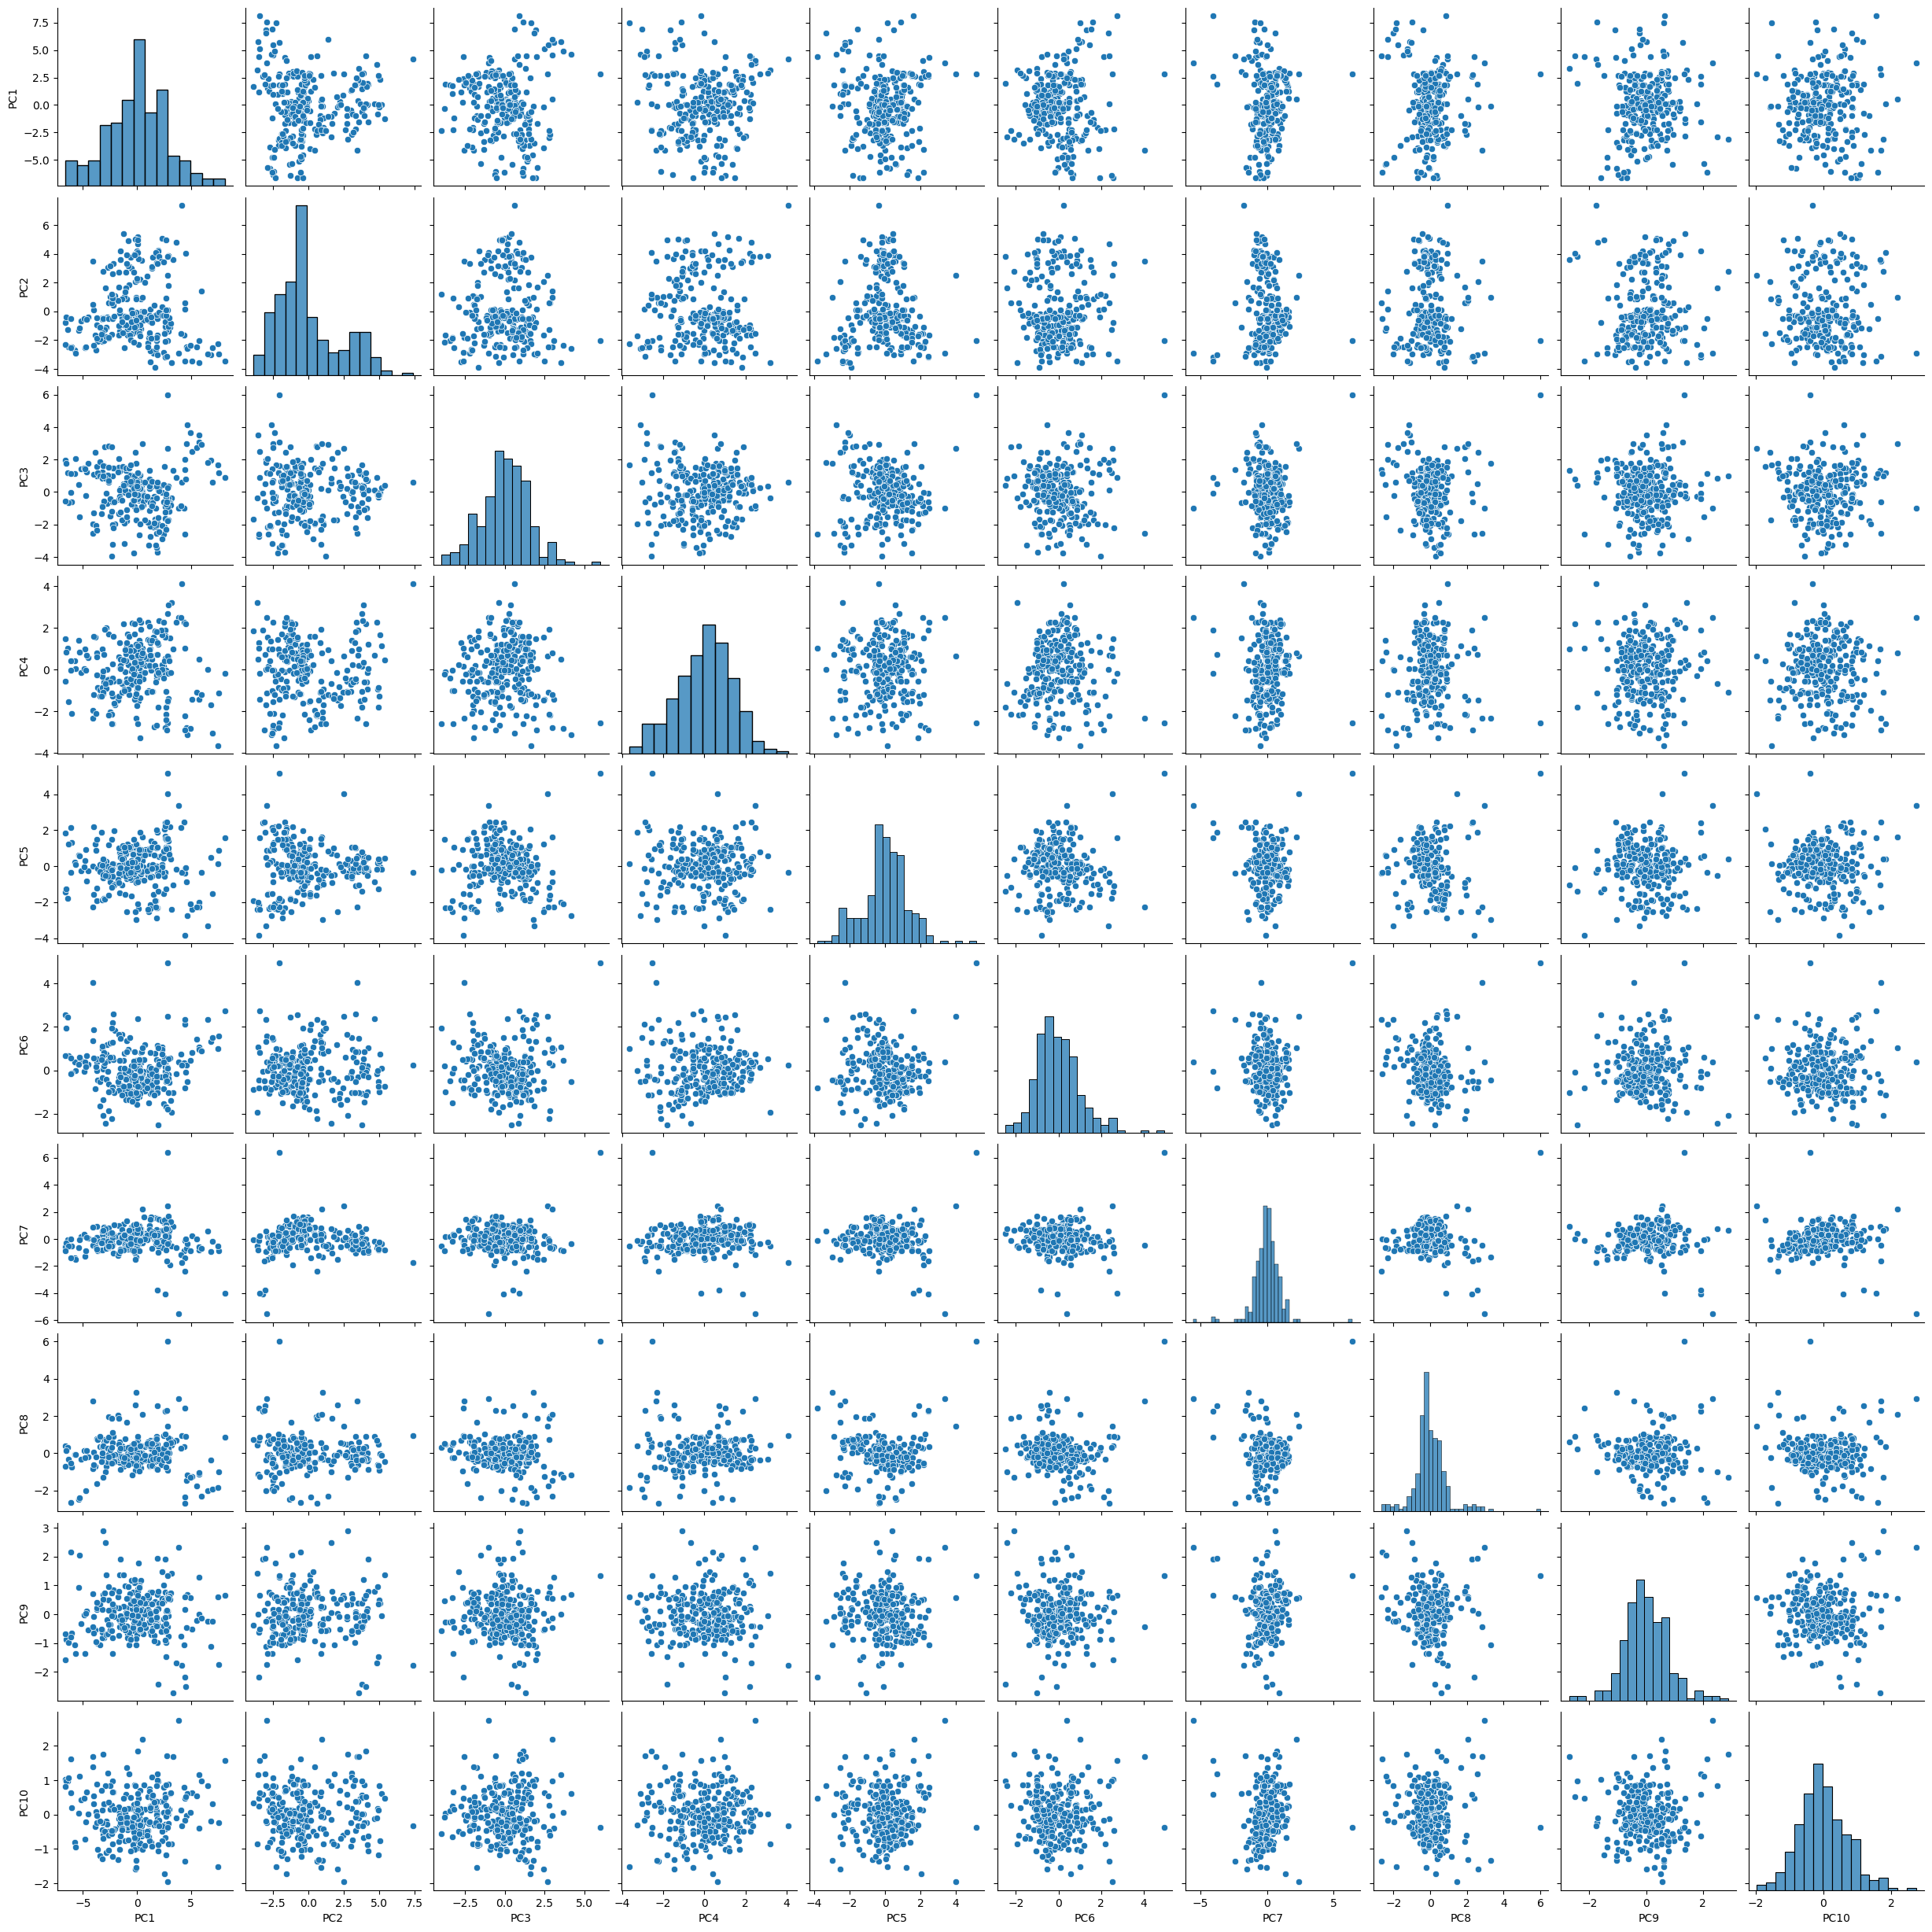

In [14]:
sns.pairplot(pd.DataFrame(scaled_data_reduced,columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]))
plt.show()

## 6. Factor analysis 

Factor analysis is another way of reducing the dimensionality of a big dataset. The basic idea of factor analysis is fairly simple: all of our measurements (the weight percentage of elements, in our case) are linear combinations of some small number of the more fundamental factors (such as lithology type, shaliness, etc). Factory analysis is a method that tries to find out these factors, simlar to PCA trying to find out the principal components, and uses these factors as a more parsimonious representation of the original measurements. To learn more about factor analysis, please click [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html) and [here](https://en.wikipedia.org/wiki/Factor_analysis).

In [15]:
from sklearn.decomposition import FactorAnalysis

In [16]:
fa_model = FactorAnalysis(n_components = 6)
fa_model.fit(scaled_data)
factor_data = fa_model.transform(scaled_data)

In [17]:
factor_data.shape

(269, 6)

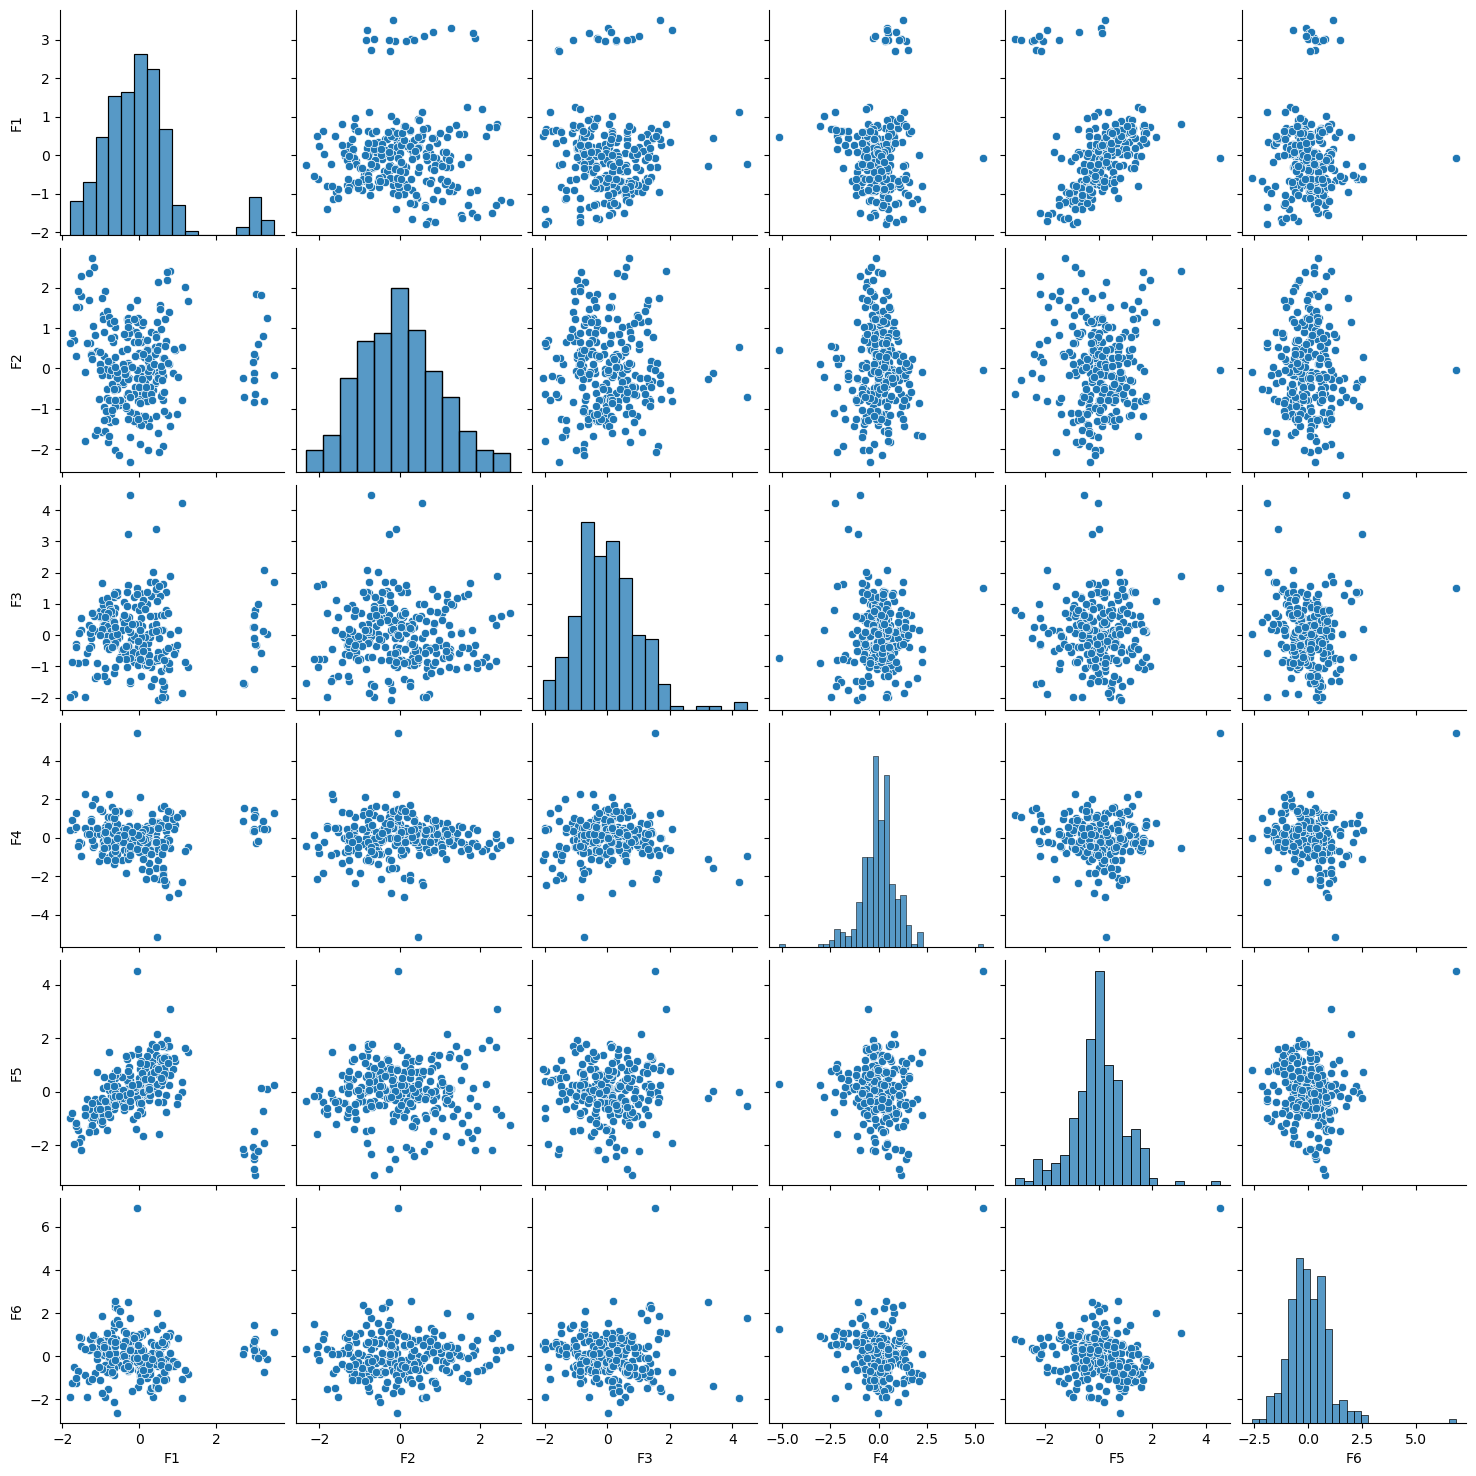

In [18]:
sns.pairplot(pd.DataFrame(factor_data,columns = ["F1","F2","F3","F4","F5","F6"]))
plt.show()

## 7. Implement K-means clustering

Now, I use the <font color=blue>**PCA-transformed data**</font> to implement K-means clustering. Also, please implement the elbow method to determine the optimal number of clusters.
<br>


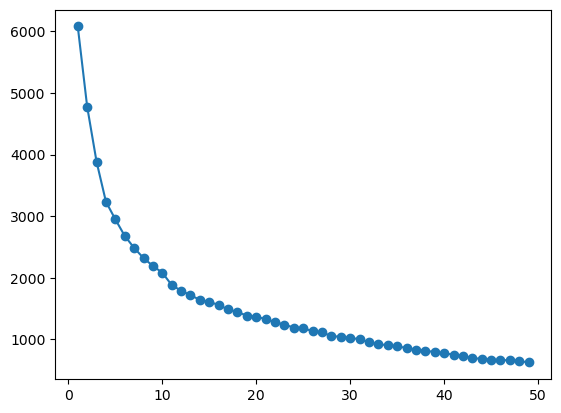

In [19]:
from sklearn.cluster import KMeans
# Elbow curve
inertia = []
numK = []
maxK = 50
for k in range(1,maxK):
    kmeans = KMeans(n_clusters = k, random_state=42).fit(scaled_data_reduced)
    numK.append(k)
    inertia.append(kmeans.inertia_)

plt.plot(numK,inertia,'-o')
plt.show()

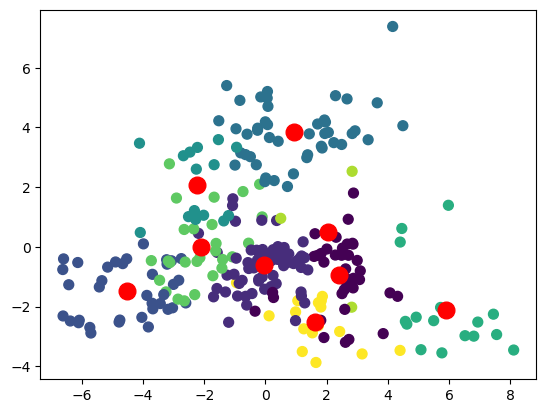

In [20]:
# Calculate the k-means
kmeans = KMeans(n_clusters = 9, random_state = 42) 
kmeans.fit(scaled_data_reduced )

# Plot the k-means cluster data
plt.scatter(scaled_data_reduced[:,0], scaled_data_reduced[:,1], s=50, c=kmeans.labels_)
plt.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], 'ro', markersize=12)
plt.show()

## 8. Visualize the clustering results

The following codes serve to visualize the clustering results. Depending on the number of clusters you have selected before, the plot might look not good. 

In [21]:
geochem_df['Cluster'] = kmeans.labels_ + 1

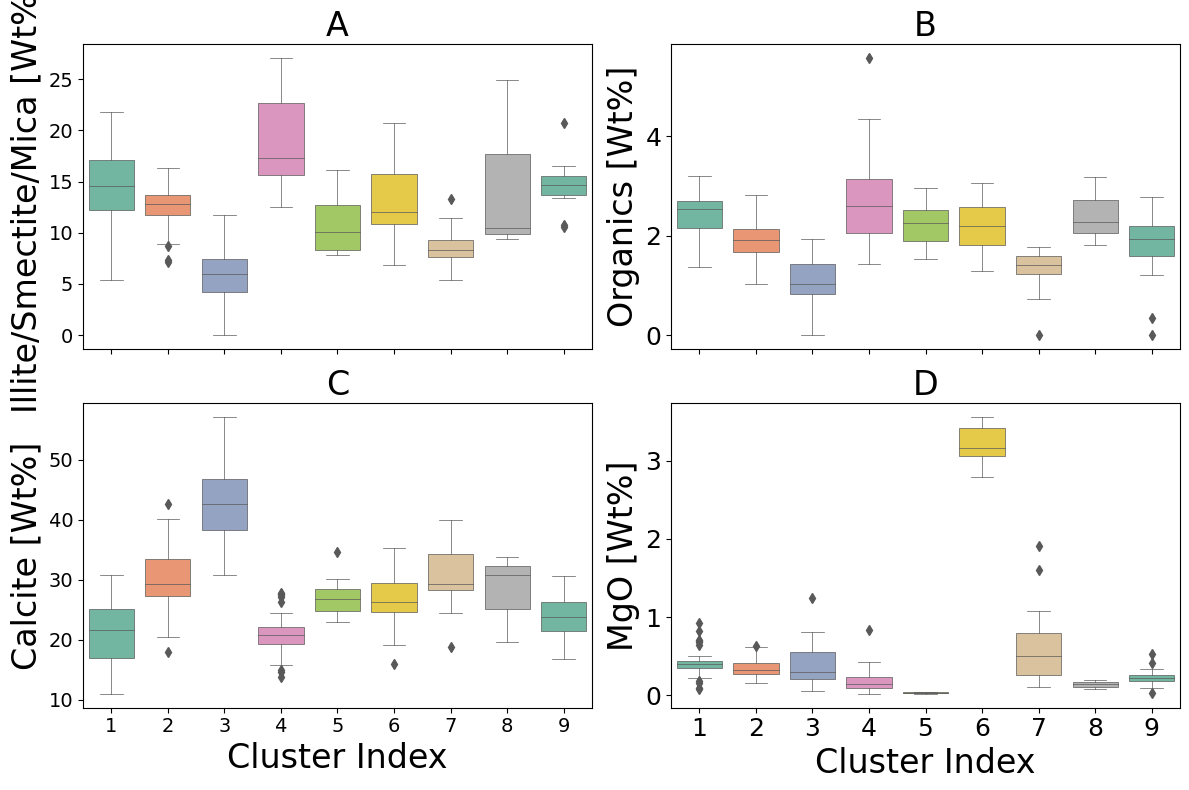

In [22]:
facies_colors = sns.color_palette("Set2", 11) # Change 11 to the optimal number of clusters that you have determined. 

fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
b= sns.boxplot(x='Cluster', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
b.set_title("A",fontsize=24)
b.set_xlabel("")
b.set_ylabel("Illite/Smectite/Mica [Wt%]",fontsize=24)
b.tick_params(labelsize=14)

b= sns.boxplot(x='Cluster', y='Organics', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
b.set_title("B",fontsize=24)
b.set_xlabel("")
b.set_ylabel("Organics [Wt%]",fontsize=24)
b.tick_params(labelsize=18)

b=sns.boxplot(x='Cluster', y='Calcite', linewidth=0.5,
            data=geochem_df, ax=ax[1,0],
            palette=facies_colors)
b.set_title("C",fontsize=24)
b.set_xlabel("Cluster Index",fontsize=24)
b.set_ylabel("Calcite [Wt%]",fontsize=24)
b.tick_params(labelsize=14)

b=sns.boxplot(x='Cluster', y='MgO', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)
b.set_title("D",fontsize=24)
b.set_xlabel("Cluster Index",fontsize=24)
b.set_ylabel("MgO [Wt%]",fontsize=24)
b.tick_params(labelsize=18)

plt.tight_layout()

In [23]:
def make_facies_log_plot(logs, facies_colors, label):
    # reset to original matplotlib style
    # seaborn doesn't look as good for this
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    #make sure logs are sorted by depth 
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 10))
    ax[0].plot(logs['IlliteSmectiteMica'], logs.Depth, '-g')
    ax[1].plot(logs['Organics'], logs.Depth, '-')
    ax[2].plot(logs['Calcite'], logs.Depth, '-', color='0.5')
    ax[3].plot(logs['MgO'], logs.Depth, '-', color='r')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11) # change 11 to the number of clusters that you have determined
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((10*' ').join(['Clust 1', 'Clust 2', 'Clust 3', 
                                'Clust 4', 'Clust 5', 'Clust 6','Clust 7', 'Clust 8', 
                                'Clust 9', 'Clust 10', 'Clust 11', ]), fontsize=7) # also change these labels accordingly
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel('Clay Minerals', fontsize=16)
    ax[0].set_xlim(logs['IlliteSmectiteMica'].min(),logs['IlliteSmectiteMica'].max())
    ax[0].set_ylabel('MD [m]', fontsize=24)
    ax[0].tick_params(labelsize=12)
    ax[0].grid(b=False)
    ax[1].set_xlabel("Organics", fontsize=16)
    ax[1].set_xlim(logs['Organics'].min(),logs['Organics'].max())
    ax[1].grid(b=False)
    ax[1].tick_params(labelsize=12)
    ax[2].set_xlabel("Calcite", fontsize=16)
    ax[2].set_xlim(logs['Calcite'].min(),logs['Calcite'].max())
    ax[2].grid(b=False)
    ax[2].tick_params(labelsize=12)
    ax[3].set_xlabel("MgO", fontsize=16)
    ax[3].set_xlim(logs['MgO'].min(),logs['MgO'].max())
    ax[3].grid(b=False)
    ax[3].tick_params(labelsize=12)
    ax[4].set_xlabel('Facies', fontsize=16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])
    
    #f.suptitle(logs.iloc[0]['Well Name'], fontsize=14,y=0.9)
    return f

/tmp/ipykernel_29327/476176368.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b=False)
/tmp/ipykernel_29327/476176368.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b=False)
/tmp/ipykernel_29327/476176368.py:50: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[2].grid(b=False)
/tmp/ipykernel_29327/476176368.py:54: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[3].grid(b=False)


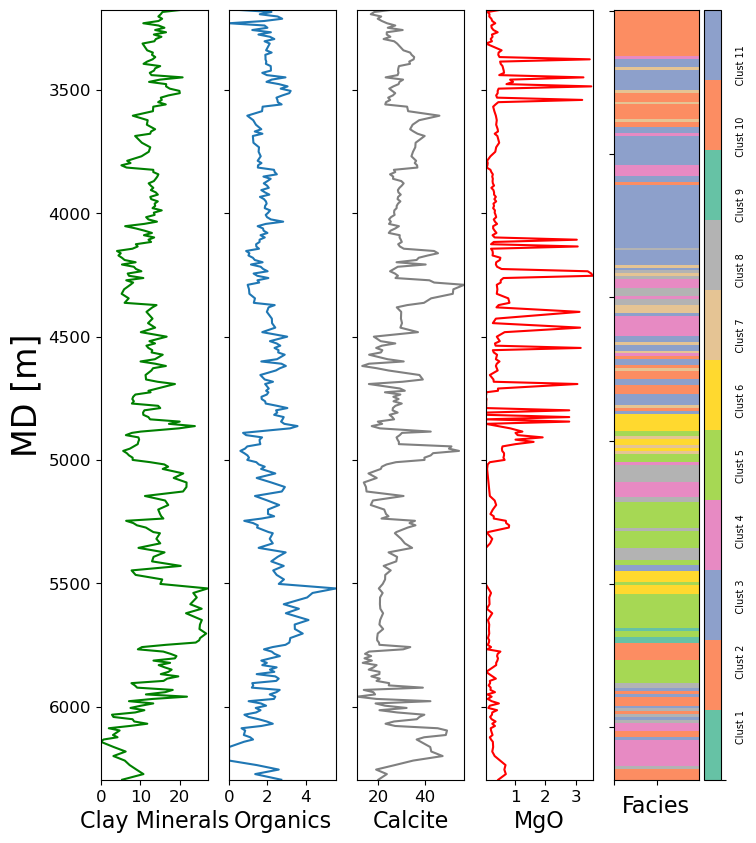

In [24]:
f = make_facies_log_plot(geochem_df,
        facies_colors, 'Cluster')
plt.show()

## 9. Summary

1. This is a method that reduces the number of features in a dataset to better visualize datasets with a large number of dimensions. It reduces the number of dimensions by obtaining a set of principle variables by correlating features.
2. K-means clustering puts data into meaningfull groups to simplify data analysis. It works by starting with initial random clusters, then it iteratively calculates the distance between each cluster and instance, assigns each instance to the nearest cluster, and then updates the cluster centers by calculating the mean of all the instances assigned at the same cluster. This process is iterated until convergence.
3. First, the data was imported into a pandas dataframe and then some basic visualization and feature engineering was preformed. Next, preprocessing was done to rescale the feature measurements so that they have a zero mean and unit variance. After the pre-processing principle component analysis (PCA) was done to reduce the dimensionality so the geochemical facies dataset retained at least 90% unit variance. After the PCA, the dataset was ready for clustering using K-means, but to find the ideal number of clusters an elbow graph was created. Using the information from the elbow graph the k-means was calculated.
4. When it comes to k-means clustering, choosing the clusters is not a straight forward affair. The elbow graph with real data may not show sharp curves such as the graph in the example.

## 10. Applications of unsupervised machine learning to geoscience 

-------------------------------------------------------------------------------
## Unsupervised learning on scientific ocean drilling datasets from the South China Sea

The authors of this paper used unsupervised learning to explore data paterns in multivariate geophysical datasets of ocean seafloor sediment cores. They used K-means clustering, self organizing maps, hierarchial clustering and random forest to form exploratory data clusters. The results were validated using lithological units and geologic time scales assigned by conventional methods. They concluded that the K-means clustering and self organizing maps performed better with lithological units while random forrest corresponded best with geologic time scales.

[Springer Link](https://link.springer.com/article/10.1007/s11707-018-0704-1)

--------------------------------------------------------------------------------
# Fault class prediction in unsupervised learning using model-based clustering approach

The authors of this paper explored the use of unserpervised ML methods due to the challenges in supervised ML methods, such as the need for historical data and problems in classifying new faults accurately. The goal is to provide a new methodology using unsupervised learning for rapid fault prediction and fault class detection using K-means clustering and density estimation via Gaussian Mixture Model (GMM) clustering. The results are compared with a real case vibration dataset. Using these methods they were able to predict faults with an accuracy of 82.96% and the GMM algorithm had a slight edge on prediction over the K-means algorithm.

[IEEE Link](https://ieeexplore.ieee.org/document/8356831)